In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 45.8 MB/s eta 0:00:00


In [ ]:
import rasterio
import torch
import torch.nn as nn
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import os
import shutil
import random
from google.colab import drive
import sys
import time
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
from torchvision import transforms

In [ ]:

#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#path = '/content/drive/MyDrive/Academico/Computer Vision'
#sys.path.append(path)

base_dir = os.getcwd()



In [ ]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def determine_max_pixel_value(data):
    max_value = 0
    for item in data:
        image = Image.open(item['image_path'])
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image_np = np.array(image)
        max_value = max(max_value, image_np.max())
    return max_value

In [ ]:



def load_data(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def scale_and_normalize_image(image, max_value):
    image = np.array(image).astype(np.float32)
    image = (image / image.max()) * 255
    return image/max_value

class TiffDataset(Dataset):
    def __init__(self, data, transform=None, max_value = 255.0):
        self.data = data
        self.transform = transform
        self.max_value = max_value

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item['image_path'])


        if image.mode != 'RGB':
            image = image.convert('RGB')

        image = scale_and_normalize_image(image, self.max_value)

        if self.transform:
            image = self.transform(image)

        label = item['label']
        return image, label


train_json_file = base_dir + '/Data/Train_80_enhanced.json'
test_json_file = base_dir + '/Data/Test_20_enhanced.json'
train_data = load_data(train_json_file)
test_data = load_data(test_json_file)

train_data = load_data(train_json_file)
test_data = load_data(test_json_file)


max_pixel_value = 255.0



transform_tr = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=180),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),







])


transform_val = transforms.Compose([
    transforms.ToTensor(),


])



train_dataset = TiffDataset(train_data, transform=transform_tr, max_value=max_pixel_value)
test_dataset = TiffDataset(test_data, transform=transform_val, max_value=max_pixel_value)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(p=0.5)


        self.feature_size = 128 * 32 * 32

        self.fc1 = nn.Linear(self.feature_size, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.pool(x)
        x = self.dropout(x)

        # Calcular el tamaño del lote dinámicamente
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Redimensionar el tensor para la capa fully connected

        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Epoch 0/99, Loss: 0.7278, Accuracy: 0.5918, Time: 4.48s
Validation Loss: 0.5779, Accuracy: 0.6708
Epoch 1/99, Loss: 0.5989, Accuracy: 0.6563, Time: 3.94s
Validation Loss: 0.5878, Accuracy: 0.7178
Epoch 2/99, Loss: 0.5710, Accuracy: 0.6811, Time: 3.94s
Validation Loss: 0.6061, Accuracy: 0.5718
Epoch 3/99, Loss: 0.5634, Accuracy: 0.6818, Time: 3.70s
Validation Loss: 0.5522, Accuracy: 0.7351
Epoch 4/99, Loss: 0.5403, Accuracy: 0.6973, Time: 4.10s
Validation Loss: 0.5369, Accuracy: 0.7228
Epoch 5/99, Loss: 0.5167, Accuracy: 0.7345, Time: 3.73s
Validation Loss: 0.5411, Accuracy: 0.7203
Epoch 6/99, Loss: 0.5030, Accuracy: 0.7339, Time: 3.70s
Validation Loss: 0.6371, Accuracy: 0.6411
Epoch 7/99, Loss: 0.4976, Accuracy: 0.7444, Time: 3.93s
Validation Loss: 0.5111, Accuracy: 0.7228
Epoch 8/99, Loss: 0.4965, Accuracy: 0.7506, Time: 3.91s
Validation Loss: 0.5256, Accuracy: 0.7277
Epoch 9/99, Loss: 0.4932, Accuracy: 0.7463, Time: 3.75s
Validation Loss: 0.5139, Accuracy: 0.7599
Epoch 10/99, Loss: 0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x785ee1096830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x785ee1096830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 72/99, Loss: 0.3983, Accuracy: 0.8108, Time: 4.01s


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x785ee1096830><function _MultiProcessingDataLoaderIter.__del__ at 0x785ee1096830>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in:     assert self._parent_pid == os.

Validation Loss: 0.4341, Accuracy: 0.8119


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x785ee1096830><function _MultiProcessingDataLoaderIter.__del__ at 0x785ee1096830><function _MultiProcessingDataLoaderIter.__del__ at 0x785ee1096830>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
            self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  F

Epoch 73/99, Loss: 0.4034, Accuracy: 0.8077, Time: 4.10s


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x785ee1096830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x785ee1096830>if w.is_alive():

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()AssertionError
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
can only test a child process    
if w.is_alive():
  File "/usr/lib/

Validation Loss: 0.4441, Accuracy: 0.8119
Epoch 74/99, Loss: 0.4038, Accuracy: 0.8158, Time: 4.02s
Validation Loss: 0.4310, Accuracy: 0.8119
Epoch 75/99, Loss: 0.4052, Accuracy: 0.8058, Time: 3.73s
Validation Loss: 0.4352, Accuracy: 0.7995
Epoch 76/99, Loss: 0.3995, Accuracy: 0.8083, Time: 3.83s
Validation Loss: 0.4325, Accuracy: 0.8045
Epoch 77/99, Loss: 0.3916, Accuracy: 0.8133, Time: 3.92s
Validation Loss: 0.4350, Accuracy: 0.7995
Epoch 78/99, Loss: 0.3941, Accuracy: 0.8195, Time: 3.83s
Validation Loss: 0.4358, Accuracy: 0.8094
Epoch 79/99, Loss: 0.4006, Accuracy: 0.8058, Time: 3.88s
Validation Loss: 0.4321, Accuracy: 0.8069
Epoch 80/99, Loss: 0.3889, Accuracy: 0.8176, Time: 3.70s
Validation Loss: 0.4409, Accuracy: 0.8020
Epoch 81/99, Loss: 0.3998, Accuracy: 0.8083, Time: 3.92s
Validation Loss: 0.4386, Accuracy: 0.8020
Epoch 82/99, Loss: 0.3954, Accuracy: 0.8220, Time: 4.03s
Validation Loss: 0.4413, Accuracy: 0.8119
Epoch 83/99, Loss: 0.3886, Accuracy: 0.8263, Time: 3.90s
Validation

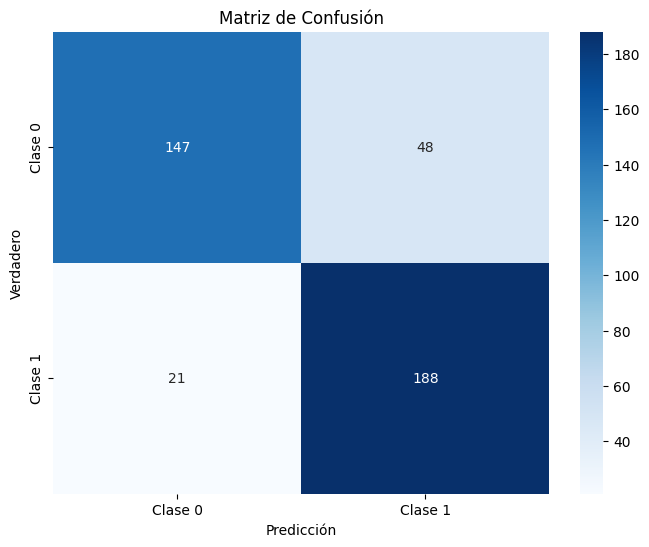

In [ ]:
import torch.nn as nn
import torch.optim as optim
import time

model = SimpleCNN()
# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1) #Drop to 0.0001 after 50 epochs

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, scheduler, num_epochs=100):
    best_acc = 0.0
    best_model_wts = None
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / len(train_loader.dataset)
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Time: {elapsed_time:.2f}s")

        # Validate the model
        model.eval()
        val_loss = 0.0
        corrects = 0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())


        val_loss /= len(val_loader.dataset)
        val_acc = corrects.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
            best_all_labels = all_labels
            best_all_preds = all_preds

    model.load_state_dict(best_model_wts)


    torch.save(model.state_dict(), base_dir + '/Redes_entrenadas/CNN_enhanced_fp.pth')
    print('Model saved with accuracy: {:.4f}'.format(best_acc))

    cm = confusion_matrix(best_all_labels, best_all_preds)
    cr = classification_report(best_all_labels, best_all_preds)
    accuracy = (np.array(best_all_preds) == np.array(best_all_labels)).mean()
    print("Matriz de Confusión:")
    print(cm)
    print("Reporte de Clasificación:")
    print(cr)
    print(f"Accuracy: {accuracy:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.title('Matriz de Confusión')
    plt.show()

# Train the model
train_model(model, criterion, optimizer, train_loader, test_loader, scheduler, num_epochs=100)
